# Histopathologic Cancer Detection Deep Model

<center>
    <h3>Utilizing deep learning to detect cancer in histopathologic images.</h3><br>
    <h5>By: Michael Hansen</h5>
    <h5>Date: 02/04/2025</h5>
    <h5>Course: DTSA5511 Deep Learning</h5>
    <h5>Instructor: Dr. Ying Sun</h5>
</center>


This notebook is an exploration into Deep Learning and it's use to detect cancer in histopathologic images. The dataset provided in this Kaggle competition is a collection of histopathologic images of breast cancer tumors. The goal is to build a model that can accurately detect cancer in these images.

The importance of being able to perform this task with a deep learning model cannot be understated as the benifits are too numerous to count. Thankfully there is a host of brilliant minds that have made a suite of tools that make this task easier. For this project I will be using the [Keras](https://keras.io/) library to build my model, and using ideas such as pooling, dropout, and batch normalization to improve the performance of my model.

The dataset can be found [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data), and was originally obtained from the [TCGA](https://portal.gdc.cancer.gov/projects/TCGA-BRCA) project. The group at kaggle removed duplicates that originated from probablistic sampling. There are roughly 220,000 labeled images for training and about 57,000 for the test set.


In [1]:
# Importing Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
from plotly.subplots import make_subplots # plotting
import plotly.graph_objs as go # plotting

from glob import glob # file handling
import os # file handling
import cv2 # image processing

# deep learning
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# analysis, data preprocessing, and model evaluation
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc


In [40]:
file_path = 'G:/My Drive/Academia/C Data/'
train_path = file_path + "train/"
test_path = file_path + "test/"
train_data_frame = pd.DataFrame({'path': [p.replace('\\', '/') for p in glob(os.path.join(train_path,'*.tif'))]})
test_data_frame = pd.DataFrame({'path': [p.replace('\\', '/') for p in glob(os.path.join(test_path,'*.tif'))]})
final_data_frame = pd.concat([train_data_frame, test_data_frame]).reset_index(drop = True)
final_data_frame['id'] = final_data_frame.path.map(lambda x: x.split('/')[5].split(".")[0])
labels = pd.read_csv(file_path + "train_labels.csv")
df_data = final_data_frame.merge(labels, on = "id")
df_data.head()

,path,id,label
0,G:/My Drive/Academia/C Data/train/5b0212d09ace...,5b0212d09aceaf5f0021bbc6cca1b1b02c0d50cc,0
1,G:/My Drive/Academia/C Data/train/5a8d75753adb...,5a8d75753adbc744c45c12744fa29b2353ea2d84,1
2,G:/My Drive/Academia/C Data/train/5b1ec76bb7cf...,5b1ec76bb7cfec19dbb807f8114889f775ca032d,1
3,G:/My Drive/Academia/C Data/train/5ab099f72ede...,5ab099f72edec5827282e8538ff000b1bc891cbe,0
4,G:/My Drive/Academia/C Data/train/5b00ba6ce53a...,5b00ba6ce53ae46bc844fa0c4663a305955494f1,1


In [41]:
def load_data(N,data_frame):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(data_frame[['label']].to_numpy())[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in data_frame.iterrows():
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [ ]:
# Lod the pictures
N_pics=10000
X,y = load_data(N=N_pics,data_frame=df_data)



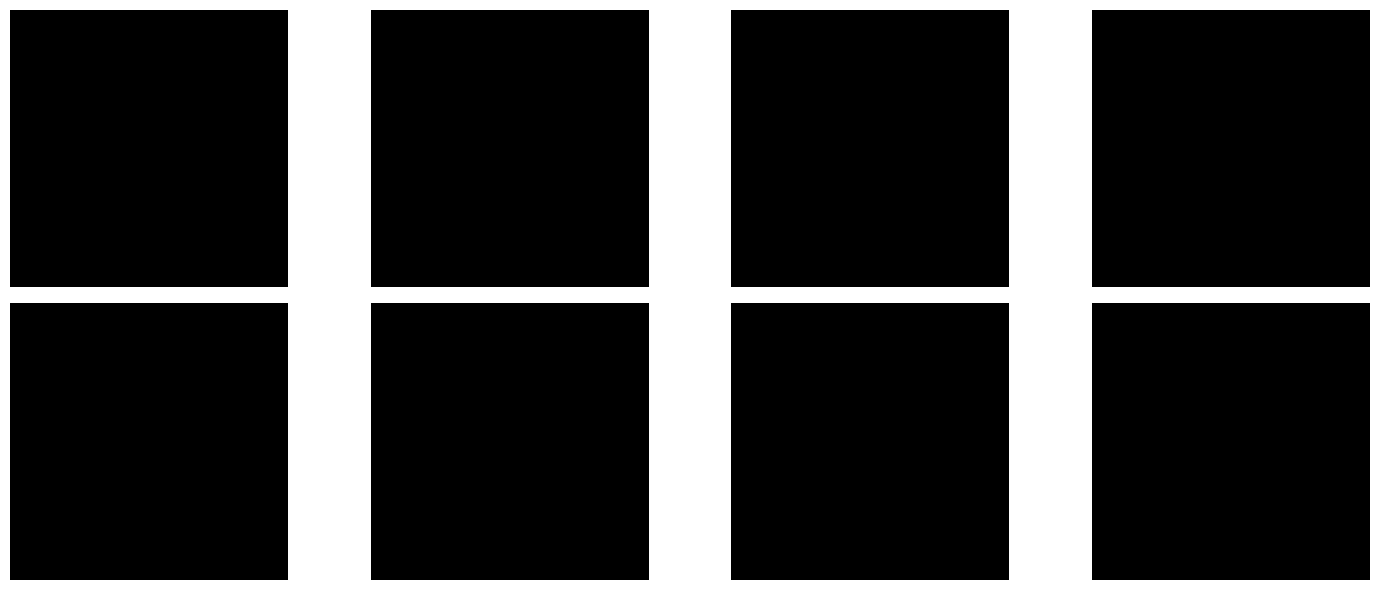


Label distribution in displayed samples:


IndexError: index 488 is out of bounds for axis 0 with size 0

In [31]:
# Display a few sample images with their labels
plt.figure(figsize=(15,6))
num_samples = 8

# Randomly select indices to display
sample_indices = np.random.randint(0, len(X), num_samples)

for plotNr, idx in enumerate(sample_indices):
    ax = plt.subplot(2, num_samples//2, plotNr+1)
    plt.imshow(X[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print distribution of labels in our sample
print(f"\nLabel distribution in displayed samples:")
unique, counts = np.unique(y[sample_indices], return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} images")

print(f"\nTotal dataset label distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} images ({count/len(y)*100:.1f}%)")


Describe images

In [ ]:
# Lay out the size and shape of the test and train

# Quick check for duplicates and NA

Describe the Data info & cleaning

Now we want to see if there is any distiguishable features we can look for visually ourselves. 
According to 
https://www.ncbi.nlm.nih.gov/books/NBK9553/#:~:text=Morphologically%2C%20the%20cancerous%20cell%20is,prominent%2C%20the%20cytoplasm%20is%20scarce
you can see differences in the size, shape, and potentially color of the cells in the images. This is good reason to dive into attributes of the pixels deeper. Each pixel has 3 channels, red, green, and blue. We can see that these are set on a scale from 0 to 255, 0 being the darkest of the color. 

And right there we have two characteristics. Brightness and Color. Both of these match characteristics listed in the article above so lets check it out. 

Comparing pairwise images would be impossible with data of this size and the resources / time at hand. What we can do is compare the amounts of each channel in each! The total sum gives the colors and the average will then give the brightness. 

In [ ]:
#  Establish a new dataframe that puts an entry for each image, with the amount of R, G, and B in each image


In [ ]:
# Graph

In [ ]:
# Distribution statistic
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples")

Describe

In [ ]:
# split data
positive_samples = X[y == 1]
negative_samples = X[y == 0]

In [ ]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

In [ ]:
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)

In [ ]:
positives_samples = None
negative_samples = None
gc.collect();

In [ ]:
training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(42) #set the seed to ensure reproducibility

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [ ]:
#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

In [ ]:
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

In [ ]:
#normally you would want to reshuffle the data between epochs, we don't as we split in-place into training/validation
epochs = 3 #how many epochs we want to perform
for epoch in range(epochs):
    #compute how many batches we'll need
    iterations = np.floor(split_idx / batch_size).astype(int) #the floor makes us discard a few samples here, I got lazy...
    loss,acc = 0,0 #we will compute running loss and accuracy
    with trange(iterations) as t: #display a progress bar
        for i in t:
            start_idx = i * batch_size #starting index of the current batch
            x_batch = X[start_idx:start_idx+batch_size] #the current batch
            y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch

            metrics = model.train_on_batch(x_batch, y_batch) #train the model on a batch

            loss = loss + metrics[0] #compute running loss
            acc = acc + metrics[1] #compute running accuracy
            t.set_description('Running training epoch ' + str(epoch)) #set progressbar title
            t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) #display metrics

In [ ]:
#compute how many batches we'll need
iterations = np.floor((y.shape[0]-split_idx) / batch_size).astype(int) #as above, not perfect
loss,acc = 0,0 #we will compute running loss and accuracy
with trange(iterations) as t: #display a progress bar
    for i in t:
        start_idx = i * batch_size #starting index of the current batch
        x_batch = X[start_idx:start_idx+batch_size] #the current batch
        y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch
        
        metrics = model.test_on_batch(x_batch, y_batch) #compute metric results for this batch using the model
        
        loss = loss + metrics[0] #compute running loss
        acc = acc + metrics[1] #compute running accuracy
        t.set_description('Running training') #set progressbar title
        t.set_description('Running validation')
        t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))
        
print("Validation loss:",loss / iterations)
print("Validation accuracy:",acc / iterations)

In [ ]:
X = None
y = None
gc.collect();

In [ ]:
base_test_dir = path + 'test/' #specify test data folder
test_files = glob(os.path.join(base_test_dir,'*.tif')) #find the test file names
submission = pd.DataFrame() #create a dataframe to hold results
file_batch = 5000 #we will predict 5000 images at a time
max_idx = len(test_files) #last index to use
for idx in range(0, max_idx, file_batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) #add the filenames to the dataframe
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0]) #add the ids to the dataframe
    test_df['image'] = test_df['path'].map(cv2.imread) #read the batch
    K_test = np.stack(test_df["image"].values) #convert to numpy array
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() #display first lines

In [ ]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file